In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import numpy as np
import torch.optim
import torch.utils.data
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import deque
import typing

import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 128
SWAG_START_EPOCH = 20  # after how many epochs of training to start collecting samples for SWAG
K_SWAG = 30  # maximum number of columns in deviation matrix D
UPDATE_INTERVAL = 1  # how often to update the SWAG model
BMA = 20  # number of samples to use for Bayesian model averaging
CIFAR10 = False  # whether to use CIFAR-10 or CIFAR-100 dataset

In [4]:
class SWAGInference(object):
    def __init__(self, train_data, trainloader, device, model, swag_start_epoch, k_swag, update_interval, bma):
        self.device = device
        print('SWAG inference using device:', self.device)

        self.model = model
        self.model.to(self.device)

        self.swag_start_epoch = swag_start_epoch
        self.k_swag = k_swag
        self.update_interval = update_interval
        self.bma = bma
        self.train_data = train_data
        self.trainloader = trainloader

        self.first_moment = self._create_weight_copy()
        self.second_moment = self._create_weight_copy()

        self.swag_n = 1

        self.deviation_queue = deque([], maxlen=self.k_swag)
        self.deviation = self._create_weight_copy()
    
    def _create_weight_copy(self) -> typing.Dict[str, torch.Tensor]:
        """Create an all-zero copy of the network weights as a dictionary that maps name -> weight"""
        return {
            name: torch.zeros_like(param, requires_grad=False)
            for name, param in self.model.named_parameters()
        }

    def update_swag(self) -> None:
        """
        Update SWAG statistics with the current weights of self.network.
        """

        # Create a copy of the current network weights
        if self.device != "cpu":
            current_params = {name: param.detach() for name, param in self.model.named_parameters()}
        else:
            current_params = {name: param.detach() for name, param in self.model.named_parameters()}

        # update swag attriutes
        for name, param in current_params.items():
            self.first_moment[name] = (self.first_moment[name] * self.swag_n + param) / (
                        self.swag_n + 1)  # update each weight
            self.second_moment[name] = (self.second_moment[name] * self.swag_n + torch.square(param)) / (
                        self.swag_n + 1)

            # Full SWAG
            self.deviation[name] = param - self.first_moment[name]

        # Full SWAG
        self.deviation_queue.append(self.deviation)

        self.swag_n += 1
    
    def fit_swag(self, loader):
        """
        Fit SWAG model using the current SWAG statistics and the training data.
        """
        optimizer = torch.optim.SGD(self.model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60,80], gamma=0.2)

        self.first_moment = {name: param.detach() for name, param in self.model.named_parameters()}
        self.second_moment = {name: torch.square(param.detach()) for name, param in self.model.named_parameters()}

        self.model.train()
        for epoch in tqdm(range(EPOCHS)):

            average_loss = 0.0
            average_accuracy = 0.0

            for i, (inputs, labels) in enumerate(loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                average_loss = (inputs.size(0) * loss.item() + i * average_loss) / (i + inputs.size(0))
                average_accuracy = (torch.sum(torch.argmax(outputs, dim=1) == labels).item() + i * average_accuracy) / (i + inputs.size(0))
            
            #print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.4f}")
            
            scheduler.step()
            if epoch >= self.swag_start_epoch and epoch % self.update_interval == 0:
                self.update_swag()
    
    def sample_parameters(self) -> None:
        """
        Sample a new network from the approximate SWAG posterior.
        For simplicity, this method directly modifies self.network in-place.
        Hence, after calling this method, self.network corresponds to a new posterior sample.
        """

        # set weights and biases
        # Instead of acting on a full vector of parameters, all operations can be done on per-layer parameters.
        for name, param in self.model.named_parameters():
            # SWAG-diagonal part
            z_1 = torch.randn(param.size()).to(self.device)
            current_mean = self.first_moment[name]
            current_std = self.second_moment[name] - torch.square(self.first_moment[name])
            assert current_mean.size() == param.size() and current_std.size() == param.size()

            # Diagonal part
            sampled_param = torch.sqrt(torch.abs(current_std)) * z_1

            rank = self.k_swag
            assert rank > 0

            z2 = torch.randn(rank).to(self.device)

            low_rank_term = torch.zeros_like(param, requires_grad=False)
            # Loop for matrix-vector multiplication
            for idx, elem in enumerate(self.deviation_queue):
                low_rank_term += z2[idx] * elem[name]

            sampled_param += 1 / ((rank - 1) ** 0.5) * low_rank_term
            # sampled_param += torch.div(low_rank_term, torch.sqrt(torch.tensor(rank - 1)))
            scale = 0.5  #  Taken from paper, could be passed as parameter
            sampled_param *= scale ** 0.5

            sampled_param += current_mean

            # Modify weight value in-place; directly changing self.model
            param.data = sampled_param

    def sample_parameters_acp(self) -> None:
        """
        Sample a new network by using the ACP on the weights of the deviation matrix D.
        """
        for name, param in self.model.named_parameters():

            current_mean = self.first_moment[name]

            deviation_param = []
            for elem in self.deviation_queue:
                tmp = elem[name].cpu().flatten().numpy()
                deviation_param.append(tmp)
            deviation_param = np.array(deviation_param)
            deviation_param = torch.tensor(deviation_param).to(self.device)
            z = torch.randn(1, 10).to(self.device)
            _, s, v = torch.svd(deviation_param)
            proj_mat = torch.diag(s).matmul(v.t())
            proj_mat = proj_mat[:10]
            sampled_param = current_mean.flatten() + z.matmul(proj_mat).squeeze()
            sampled_param = sampled_param.reshape(current_mean.size())

            param.data = sampled_param
            
    
    def _update_batchnorm(self) -> None:
        """
        Reset and fit batch normalization statistics using the training dataset self.train_dataset.
        """

        old_momentum_parameters = dict()
        for module in self.model.modules():
            # Only need to handle batchnorm modules
            if not isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
                continue

            # Store old momentum value before removing it
            old_momentum_parameters[module] = module.momentum
            module.momentum = None

            # Reset batch normalization statistics
            module.reset_running_stats()

        self.model.train()
        for (inputs, _) in self.trainloader:
            inputs = inputs.to(self.device)
            self.model(inputs)
        self.model.eval()

        # Restore old `momentum` hyperparameter values
        for module, momentum in old_momentum_parameters.items():
            module.momentum = momentum

    def predict_probabilities_swag(self, loader):
        """
        Predict class probabilities using the SWAG model performing Bayesian model averaging.
        """
        self.model.eval()
        model_predictions = []

        print("Bayesian model averaging (BMA) with {} samples".format(self.bma))
        for _ in tqdm(range(self.bma)):
            self.sample_parameters()
            self._update_batchnorm()

            predictions = []
            for (inputs, _) in loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                pred = torch.nn.functional.softmax(outputs, dim=1)
                predictions.append(pred.detach().cpu().numpy())

            model_predictions.append(np.concatenate(predictions, axis=0))
        
        bma_predictions = np.mean(model_predictions, axis=0)
        return bma_predictions
    
    def predict_labels_swag(self, predicted_probabilities):
        """
        Predict class labels using the SWAG model performing Bayesian model averaging.
        """
        predicted_labels = np.argmax(predicted_probabilities, axis=1)
        return predicted_labels


In [5]:
def calc_calibration_curve(predicted_probabilities: np.ndarray, labels: np.ndarray, num_bins: int):
    """
    Calculates a calibration curve to be used in reliability diagrams and returns an ECE
    """

    num_samples, num_classes = predicted_probabilities.shape
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    confidences = predicted_probabilities[range(num_samples), predicted_classes]
    bins = np.linspace(start=0, stop=1, num=num_bins + 1)

    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]
    accuracies = predicted_classes == labels

    calib_confidence = np.zeros(num_bins, dtype=np.float32)
    calib_accuracy = np.zeros(num_bins, dtype=np.float32)
    ratios = np.zeros(num_bins, dtype=np.float32)
    ece = 0.0

    for bin_i, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        in_bin = (confidences > bin_lower) * (confidences < bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            calib_confidence[bin_i] = avg_confidence_in_bin
            calib_accuracy[bin_i] = accuracy_in_bin
            ratios[bin_i] = prop_in_bin

    return {
        "calib_confidence": calib_confidence,
        "calib_accuracy": calib_accuracy,
        "p": ratios,
        "bins": bins,
        "ece": ece,
    }

In [6]:
def draw_reliability_diagram(out, title="Reliability Diagram", xlabel="Confidence", ylabel="Accuracy"):
    """Draws a reliability diagram into a subplot."""
    fig, ax = plt.subplots()
    accuracies = out["calib_accuracy"]
    confidences = out["calib_confidence"]
    counts = out["p"]
    bins = out["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size / 2.0

    widths = bin_size
    alphas = 0.3

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.0
    colors[:, 1] = 60 / 255.0
    colors[:, 2] = 60 / 255.0
    colors[:, 3] = alphas

    gap_plt = ax.bar(
        positions,
        np.abs(accuracies - confidences),
        bottom=np.minimum(accuracies, confidences),
        width=widths,
        edgecolor=colors,
        color=colors,
        linewidth=1,
        label="Gap",
    )

    acc_plt = ax.bar(
        positions,
        0,
        bottom=accuracies,
        width=widths,
        edgecolor="black",
        color="black",
        alpha=1.0,
        linewidth=3,
        label="Accuracy",
    )

    ax.set_aspect("equal")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(handles=[gap_plt, acc_plt])
    fig.tight_layout()
    return fig

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate(swag: SWAGInference, testloader, testset):

    print("Evaluation of SWAG model on the test set\n")

    pred_prob_all = swag.predict_probabilities_swag(testloader)

    pred_labels = swag.predict_labels_swag(pred_prob_all)

    accuracy = accuracy_score(testset.targets, pred_labels)
    precision = precision_score(testset.targets, pred_labels, average='weighted')
    recall = recall_score(testset.targets, pred_labels, average='weighted')
    f1 = f1_score(testset.targets, pred_labels, average='weighted')

    calibration_data = calc_calibration_curve(pred_prob_all, testset.targets, num_bins=20)
    print("\nValidation ECE:", calibration_data["ece"])
    fig = draw_reliability_diagram(calibration_data)
    plt.show()

    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [8]:
import torchvision.transforms as transforms
import torchvision


# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Load CIFAR-10 dataset
if CIFAR10:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
else:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

if CIFAR10:
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
else:
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 169001437/169001437 [00:06<00:00, 26808877.76it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

model = models.resnet18(pretrained=False, num_classes=100).to(device)

swag = SWAGInference(trainset.data, trainloader, device, model=model, swag_start_epoch=SWAG_START_EPOCH, k_swag=K_SWAG, update_interval=UPDATE_INTERVAL, bma=BMA)

swag.fit_swag(trainloader)

SWAG inference using device: cuda:0


100%|██████████| 100/100 [10:16<00:00,  6.16s/it]


Evaluation of SWAG model on the test set

Bayesian model averaging (BMA) with 20 samples


100%|██████████| 20/20 [02:05<00:00,  6.30s/it]



Validation ECE: 0.15872490537166592


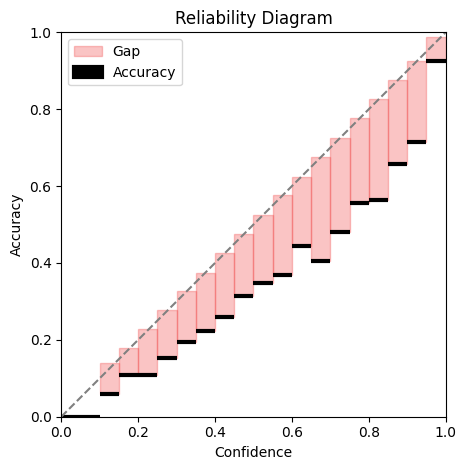


Accuracy: 0.5379
Precision: 0.5366295039257134
Recall: 0.5379
F1 Score: 0.5359495450693085


In [10]:
with torch.random.fork_rng():
    evaluate(swag, testloader, testset)

In [11]:
model_no_swag = models.resnet18(pretrained=False, num_classes=100).to(device)

optimizer = torch.optim.SGD(model_no_swag.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60,80], gamma=0.2)

model_no_swag.train()
for epoch in tqdm(range(EPOCHS)):

    average_loss = 0.0
    average_accuracy = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_no_swag(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        average_loss = (inputs.size(0) * loss.item() + i * average_loss) / (i + inputs.size(0))
        average_accuracy = (torch.sum(torch.argmax(outputs, dim=1) == labels).item() + i * average_accuracy) / (i + inputs.size(0))
        #print(f"Epoch {epoch + 1}/{EPOCHS}, Batch {i + 1}/{len(trainloader)}, Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.2f}", end="\r")
    
    scheduler.step()

100%|██████████| 100/100 [10:07<00:00,  6.08s/it]



Validation ECE: 0.21452088299095629


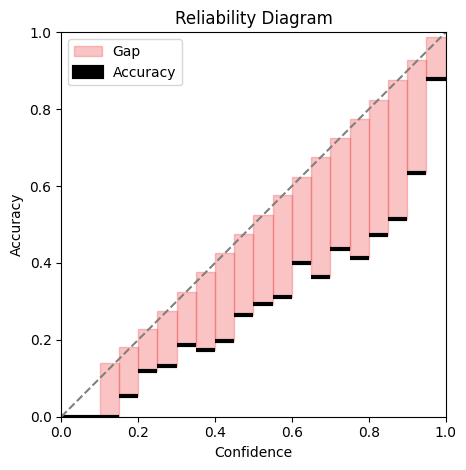

Accuracy: 0.5214
Precision: 0.5220708056042743
Recall: 0.5214
F1 Score: 0.5203824700885659


In [12]:
model_no_swag.eval()

preds = []
for (inputs, labels) in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_no_swag(inputs)
    pred = torch.nn.functional.softmax(outputs, dim=1)
    preds.append(pred.detach().cpu().numpy())
    
pred_no_swag = np.concatenate(preds, axis=0)
pred_labels_no_swag = np.argmax(pred_no_swag, axis=1)

accuracy_ns = accuracy_score(testset.targets, pred_labels_no_swag)
precision_ns = precision_score(testset.targets, pred_labels_no_swag, average='weighted')
recall_ns = recall_score(testset.targets, pred_labels_no_swag, average='weighted')
f1_ns = f1_score(testset.targets, pred_labels_no_swag, average='weighted')

calibration_data_ns = calc_calibration_curve(pred_no_swag, testset.targets, num_bins=20)
print("\nValidation ECE:", calibration_data_ns["ece"])

fig = draw_reliability_diagram(calibration_data_ns)
plt.show()

print("Accuracy:", accuracy_ns)
print("Precision:", precision_ns)
print("Recall:", recall_ns)
print("F1 Score:", f1_ns)